In [43]:
import torch
from torchvision import datasets
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import os
from PIL import Image
import torch.nn.functional as F
import cv2
from torch import nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Shape of the image array:  (120, 120, 4)


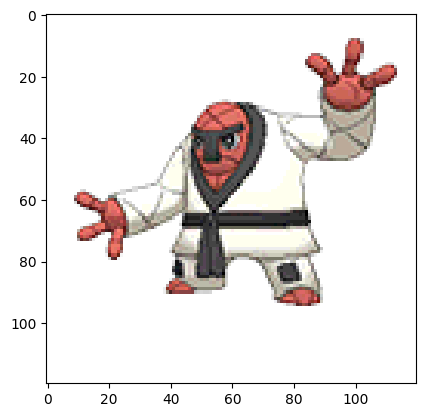

In [44]:
path = "/kaggle/input/pokemon-images-and-types/images"
for file_name in os.listdir(path):
    image_path = os.path.join(path, file_name)
    image = Image.open(image_path)
    image_array = np.array(image)
    print("Shape of the image array: ", image_array.shape)
    plt.imshow(image)
    break


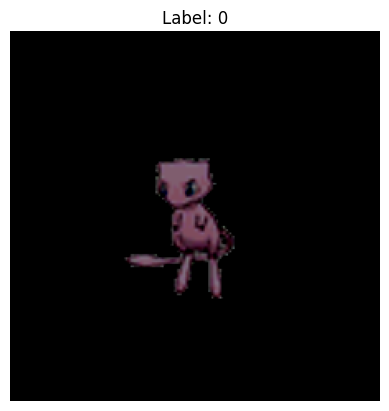

In [45]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming you want to resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
])

# Read the full dataset
full_dataset = datasets.ImageFolder(root='/kaggle/input/pokemon-images-and-types/', transform=transform)


# Load the data
train_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)

for images, labels in train_loader:
    # Extract the first image and its corresponding label
    image = images[0]  # Assuming batch size is not less than 1
    label = labels[0]
    
    image_np = image.permute(1, 2, 0).numpy()
    
    # Display the image
    plt.imshow(image_np)
    plt.title('Label: {}'.format(label))
    plt.axis('off')
    plt.show()
    
    break


In [46]:
train_data = torch.cat([images.view(images.size(0), -1) for images, _ in train_loader], dim=0)
variance = torch.var(train_data)
print(variance)


tensor(0.0539)


In [47]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,out_channels=num_residual_hiddens,kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,out_channels=num_hiddens, kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)
    
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,out_channels=num_hiddens//2,kernel_size=4, stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,out_channels=num_hiddens,kernel_size=4,stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,out_channels=num_hiddens,kernel_size=3,stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,num_hiddens=num_hiddens,num_residual_layers=num_residual_layers,num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,out_channels=num_hiddens,kernel_size=3, stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,num_hiddens=num_hiddens,num_residual_layers=num_residual_layers,num_residual_hiddens=num_residual_hiddens)
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,out_channels=num_hiddens//2,kernel_size=4, stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, out_channels=3,kernel_size=4, stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)
        

In [48]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [49]:
class VQVAE(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(VQVAE, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,num_residual_layers, num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dim,kernel_size=1, stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,commitment_cost)
        self._decoder = Decoder(embedding_dim,num_hiddens, num_residual_layers, num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity


2000 iterations
Reconstruction Error: 0.062
VQ Loss: 0.003
Perplexity: 3.863



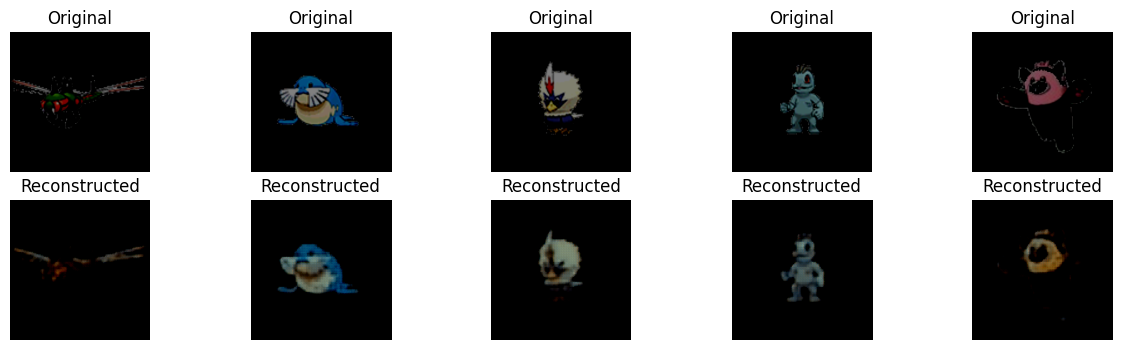

4000 iterations
Reconstruction Error: 0.043
VQ Loss: 0.002
Perplexity: 4.986



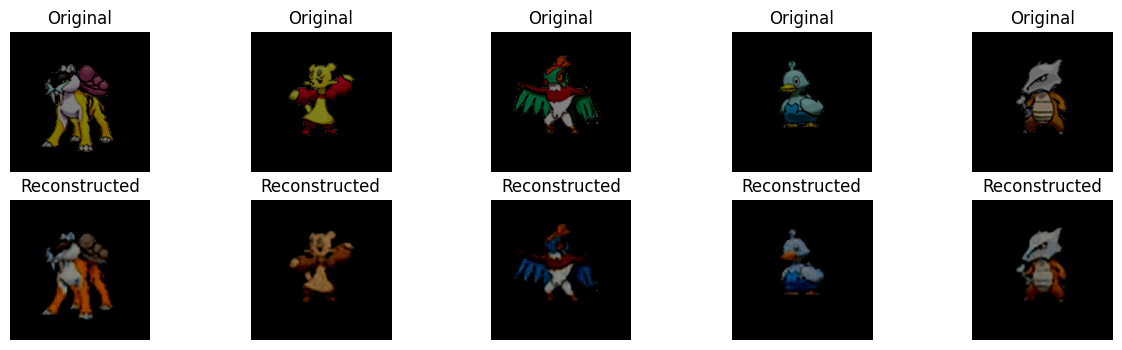

6000 iterations
Reconstruction Error: 0.059
VQ Loss: 0.003
Perplexity: 4.003



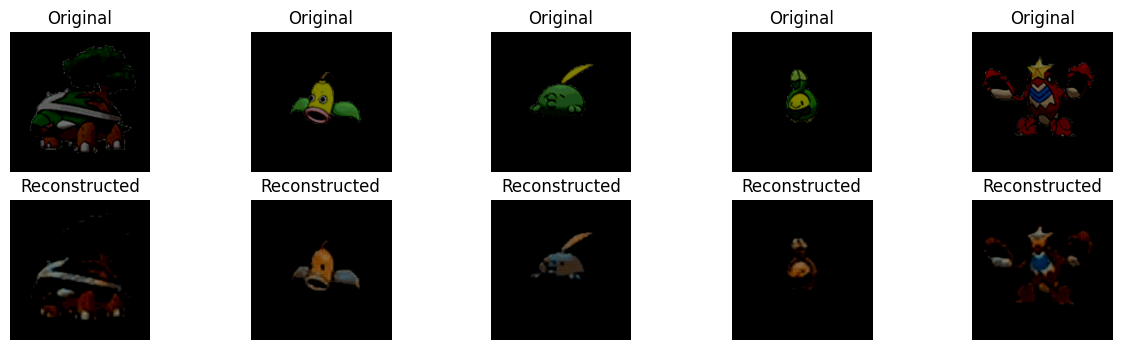

8000 iterations
Reconstruction Error: 0.089
VQ Loss: 0.004
Perplexity: 4.158



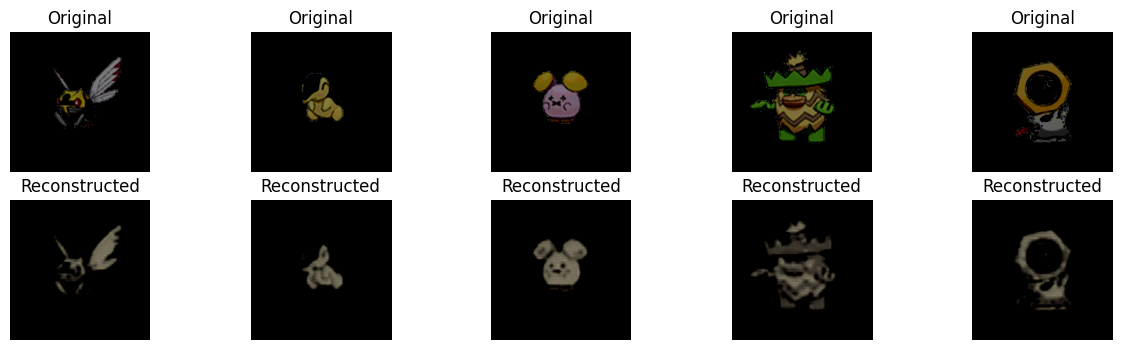

10000 iterations
Reconstruction Error: 0.040
VQ Loss: 0.003
Perplexity: 7.288



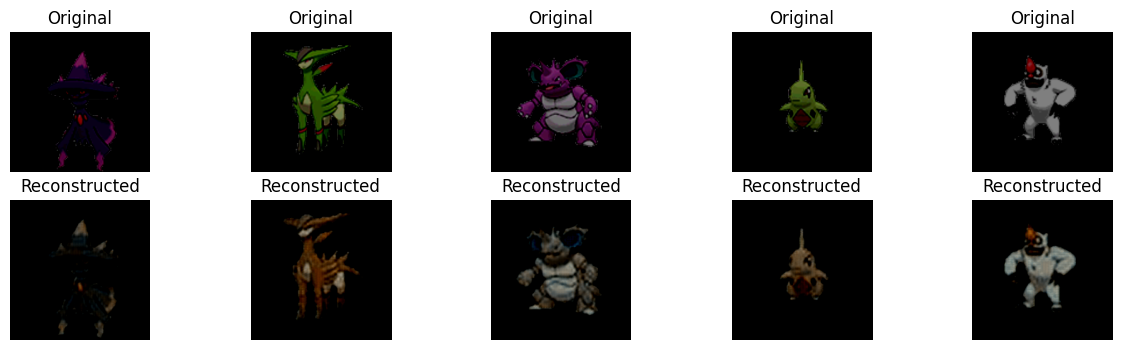

12000 iterations
Reconstruction Error: 0.028
VQ Loss: 0.003
Perplexity: 10.136



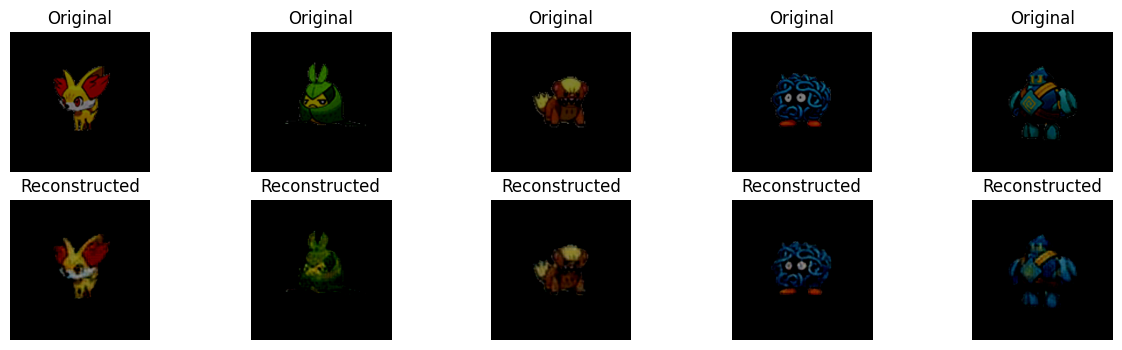

14000 iterations
Reconstruction Error: 0.023
VQ Loss: 0.003
Perplexity: 9.210



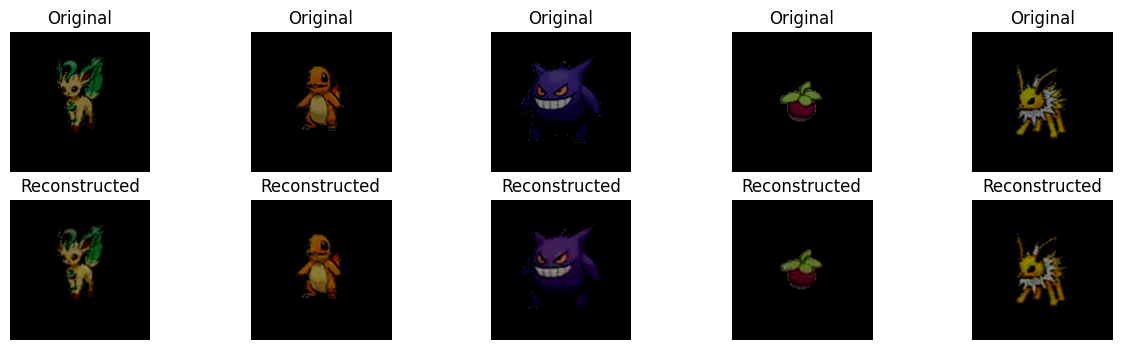

16000 iterations
Reconstruction Error: 0.045
VQ Loss: 0.005
Perplexity: 7.353



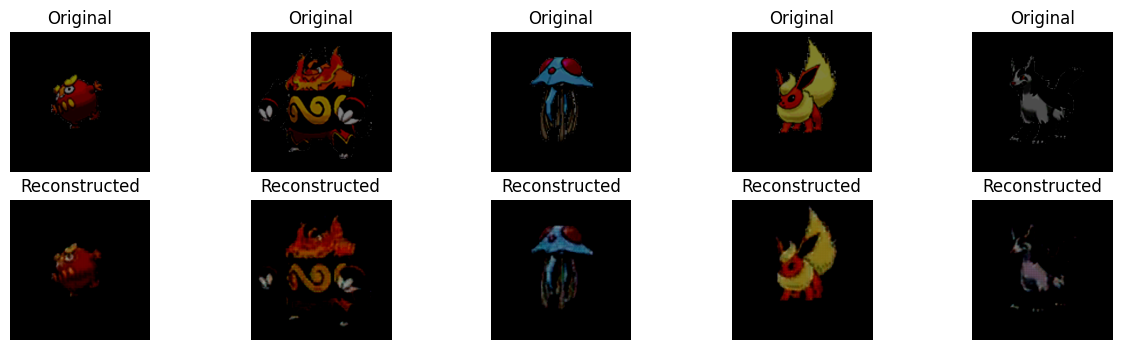

18000 iterations
Reconstruction Error: 0.024
VQ Loss: 0.003
Perplexity: 11.204



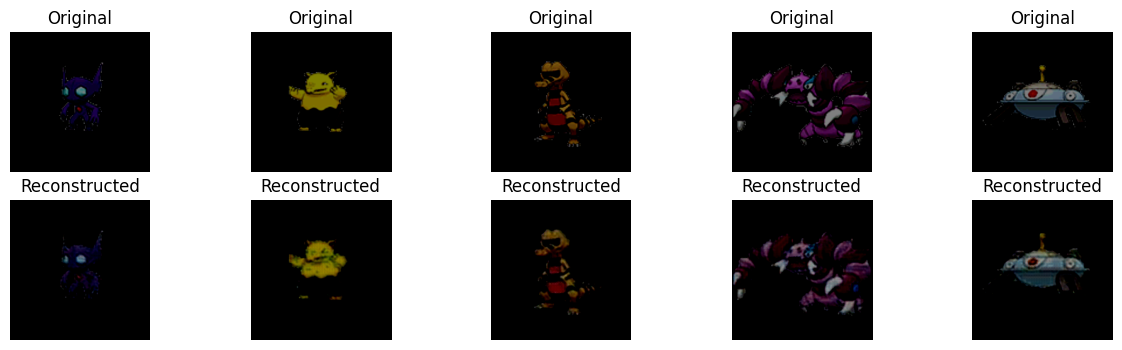

20000 iterations
Reconstruction Error: 0.022
VQ Loss: 0.003
Perplexity: 11.553



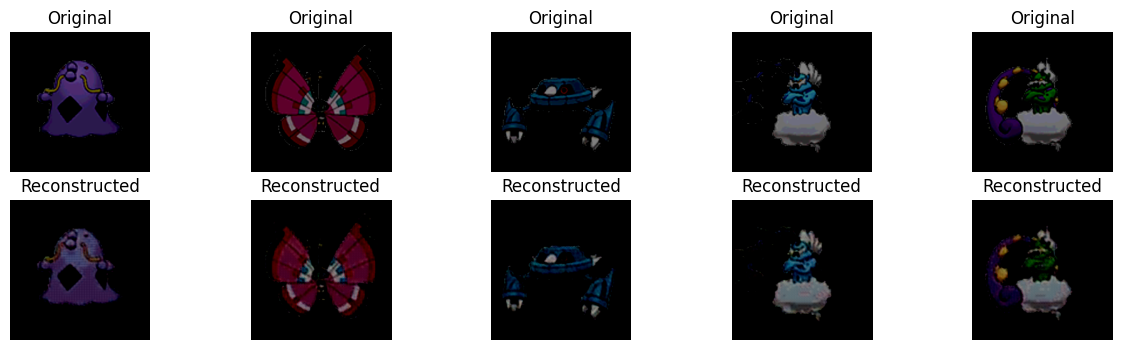

22000 iterations
Reconstruction Error: 0.018
VQ Loss: 0.003
Perplexity: 10.283



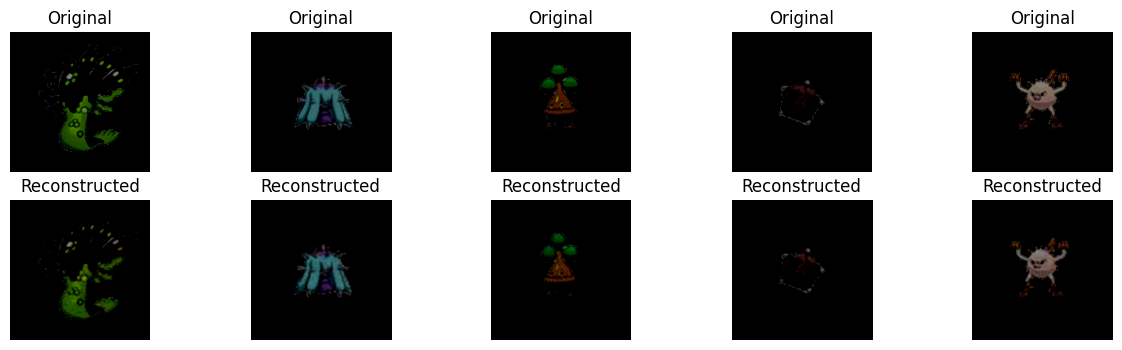

24000 iterations
Reconstruction Error: 0.016
VQ Loss: 0.004
Perplexity: 8.813



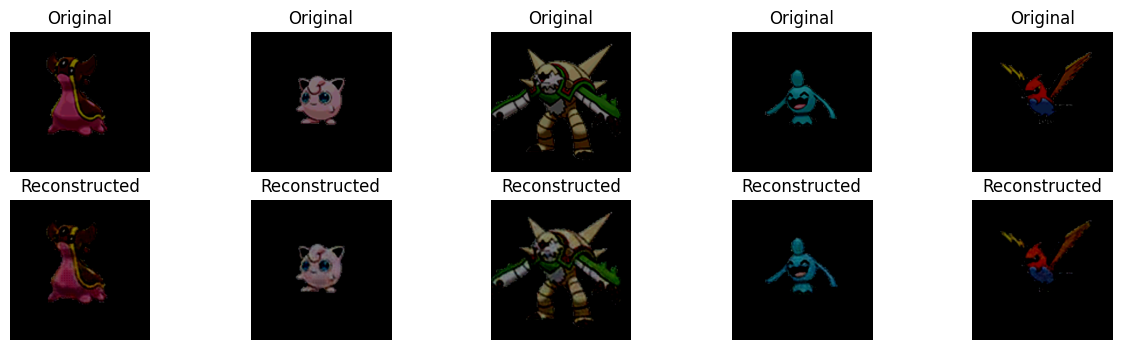

26000 iterations
Reconstruction Error: 0.016
VQ Loss: 0.003
Perplexity: 7.813



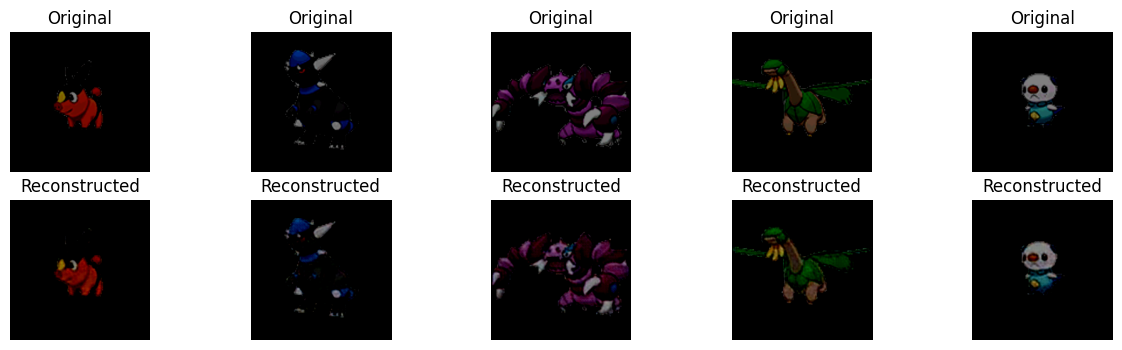

28000 iterations
Reconstruction Error: 0.013
VQ Loss: 0.004
Perplexity: 8.809



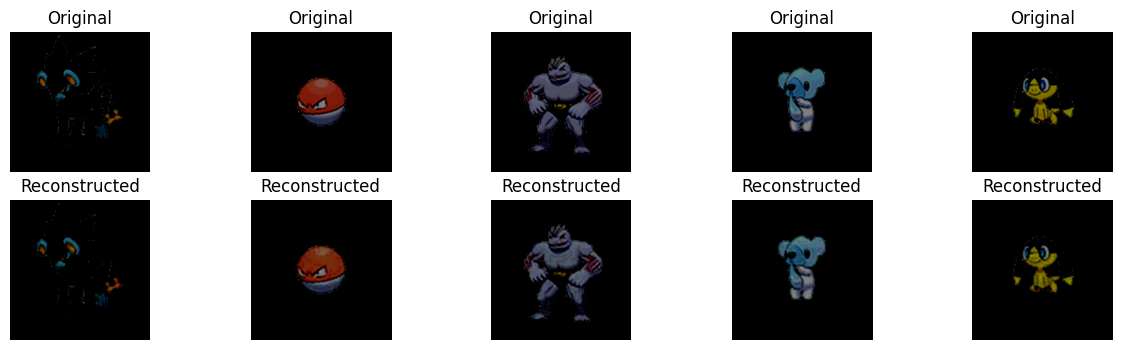

30000 iterations
Reconstruction Error: 0.012
VQ Loss: 0.005
Perplexity: 10.944



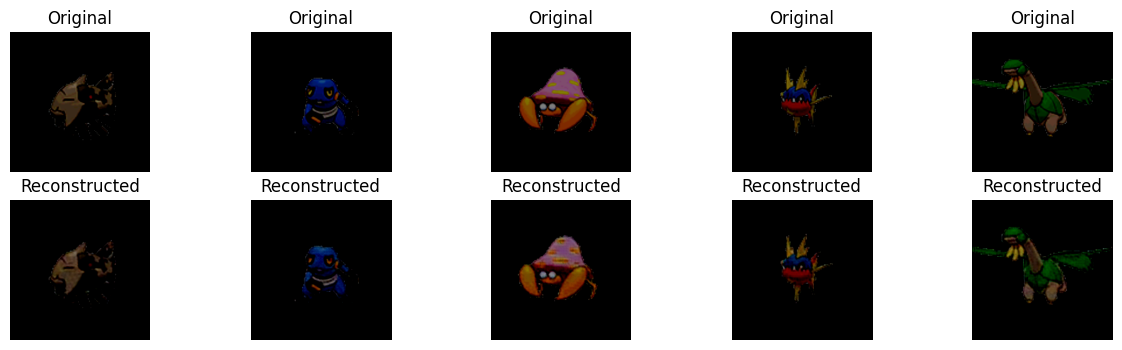

32000 iterations
Reconstruction Error: 0.021
VQ Loss: 0.002
Perplexity: 7.882



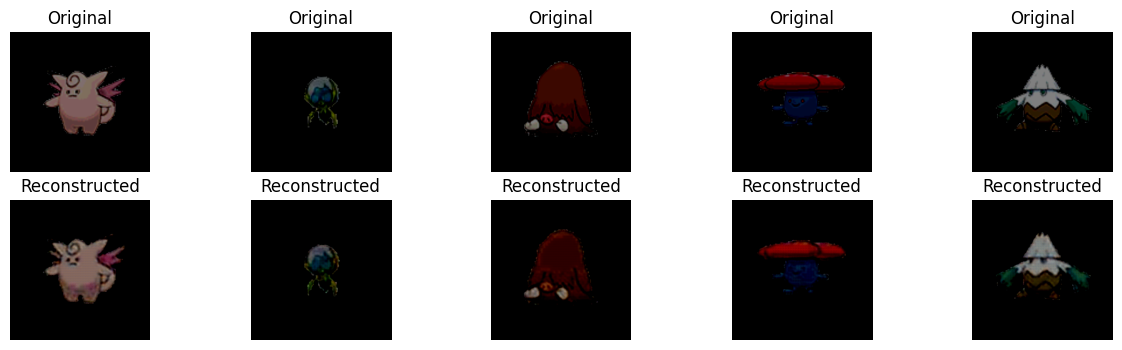

34000 iterations
Reconstruction Error: 0.016
VQ Loss: 0.002
Perplexity: 11.118



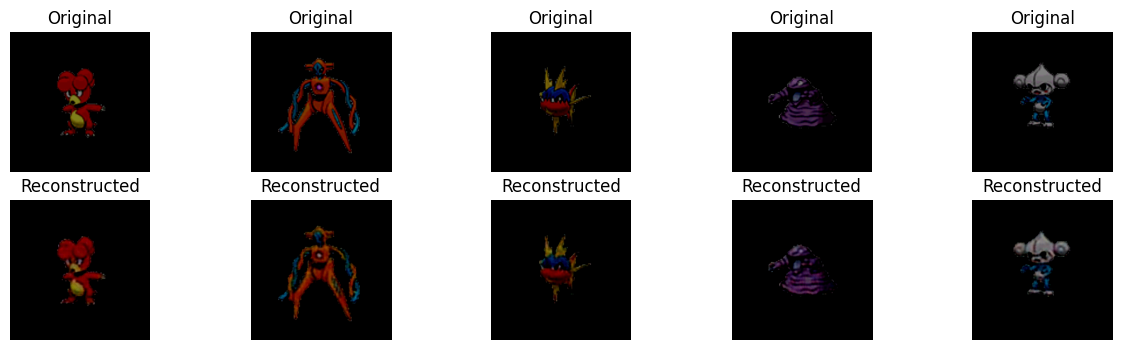

36000 iterations
Reconstruction Error: 0.014
VQ Loss: 0.003
Perplexity: 11.208



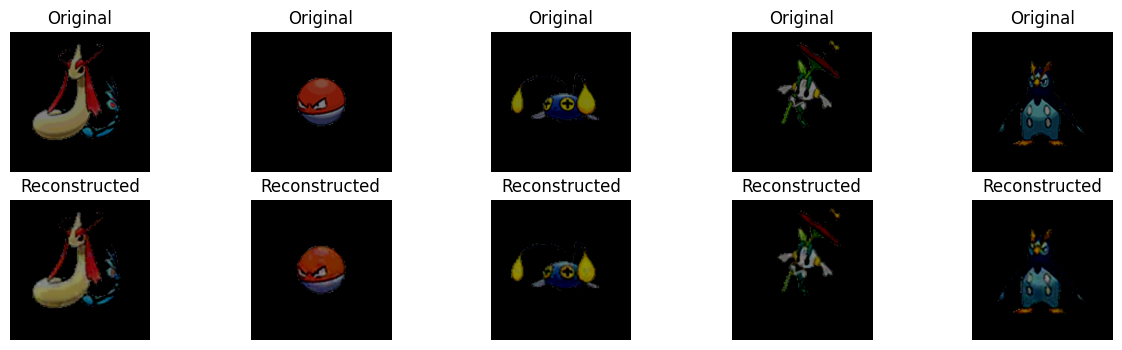

38000 iterations
Reconstruction Error: 0.012
VQ Loss: 0.003
Perplexity: 13.077



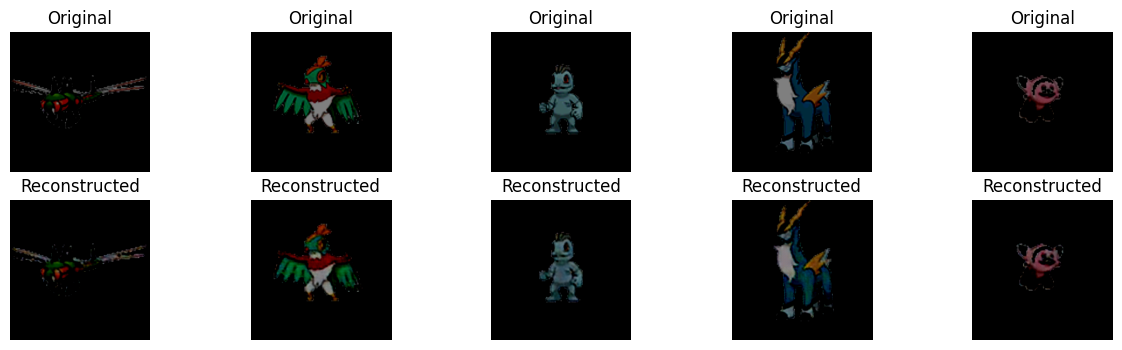

40000 iterations
Reconstruction Error: 0.011
VQ Loss: 0.003
Perplexity: 13.238



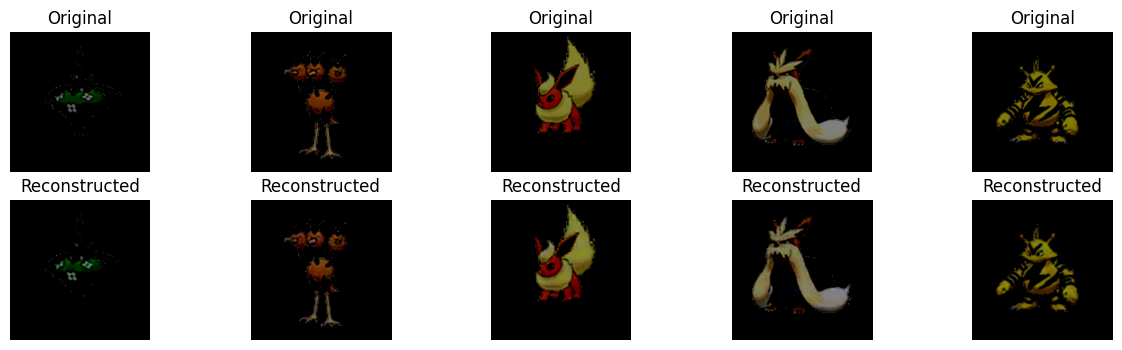

42000 iterations
Reconstruction Error: 0.010
VQ Loss: 0.003
Perplexity: 11.875



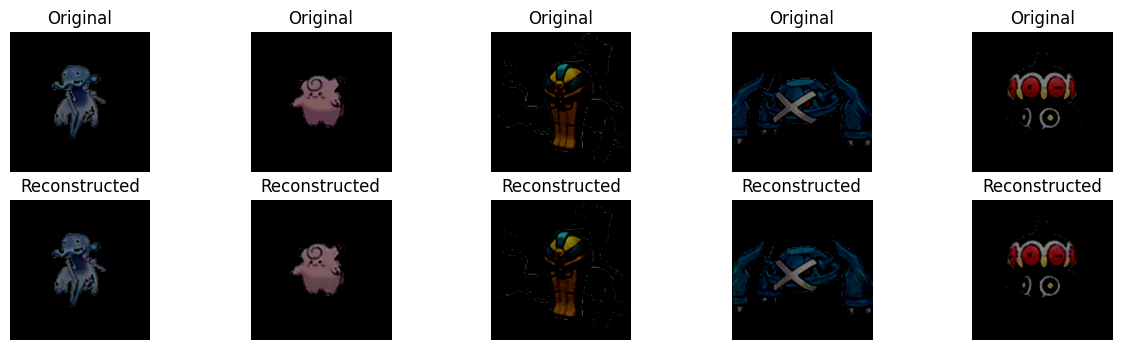

44000 iterations
Reconstruction Error: 0.010
VQ Loss: 0.002
Perplexity: 8.973



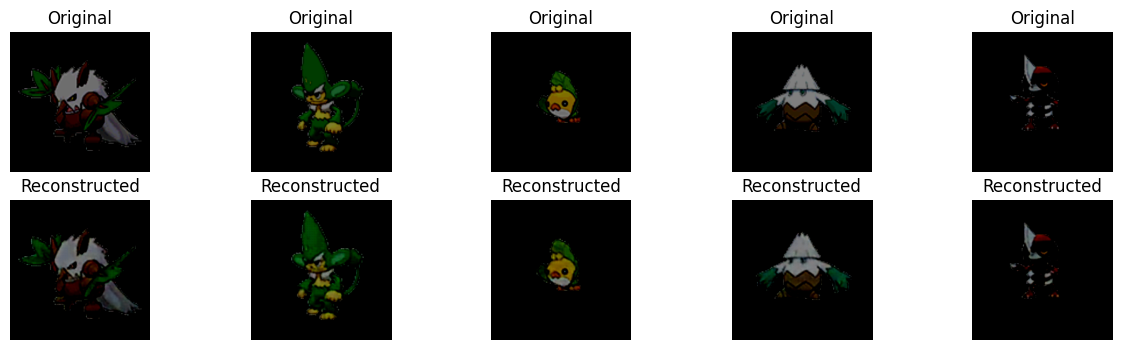

46000 iterations
Reconstruction Error: 0.010
VQ Loss: 0.002
Perplexity: 9.156



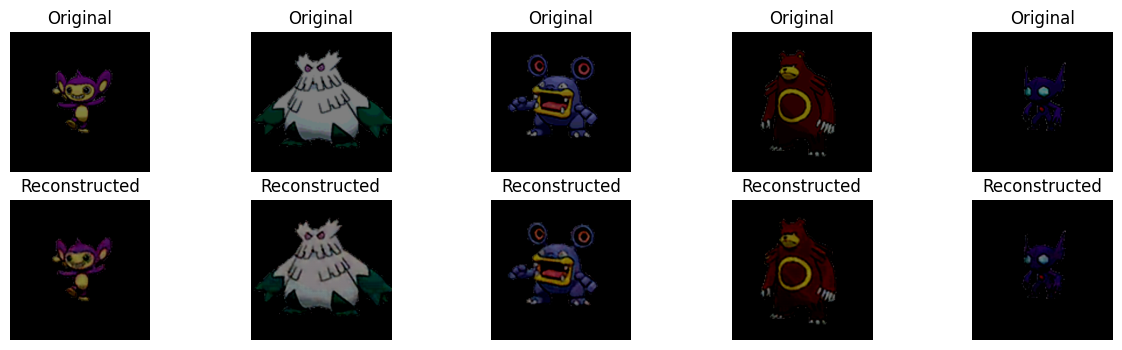

48000 iterations
Reconstruction Error: 0.010
VQ Loss: 0.002
Perplexity: 8.645



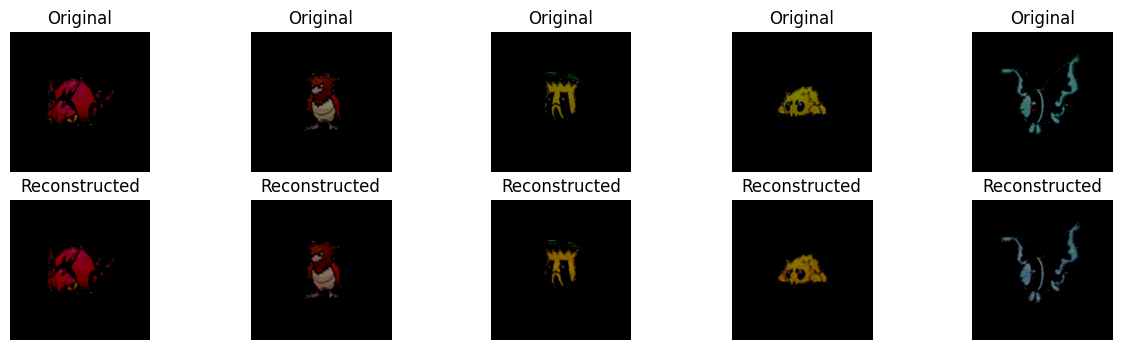

50000 iterations
Reconstruction Error: 0.010
VQ Loss: 0.002
Perplexity: 9.200



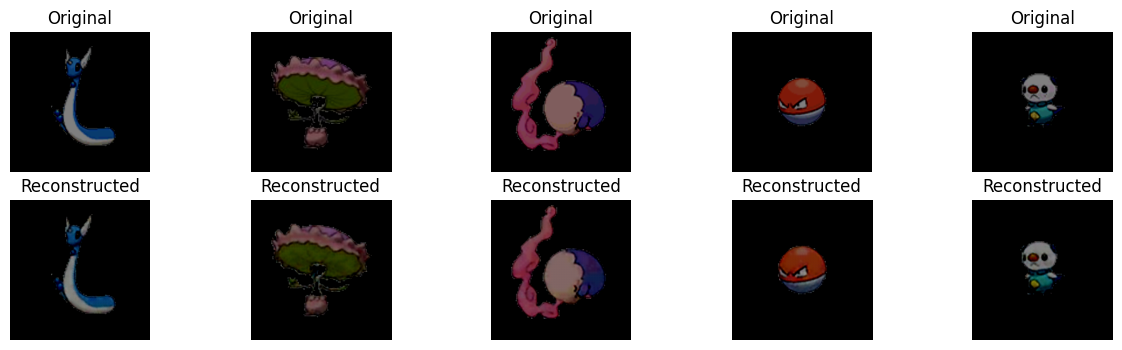

In [52]:

import torch.optim as optim

batch_size = 16
num_training_updates = 50000
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512
commitment_cost = 0.25
decay = 0.99

learning_rate = 1e-3

model = VQVAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in range(num_training_updates):
    # Get the next batch of data
    (data, _) = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()

    # Forward pass
    vq_loss, data_recon, perplexity = model(data)
    
    # Calculate reconstruction error
    recon_error = F.mse_loss(data_recon, data) / variance
    
    # Total loss
    loss = recon_error + vq_loss
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Append reconstruction error and perplexity to lists for tracking
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 2000 == 0:
        print('%d iterations' % (i+1))
        print('Reconstruction Error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('VQ Loss: %.3f' % vq_loss.item())
        print('Perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()
        
        # Visualize reconstructed images (optional)
        # Plot some original and reconstructed images
        num_images_to_plot = 5
        fig, axes = plt.subplots(2, num_images_to_plot, figsize=(15, 4))
        for j in range(num_images_to_plot):
            # Original images
            axes[0, j].imshow(data[j].cpu().permute(1, 2, 0).numpy())
            axes[0, j].set_title('Original')
            axes[0, j].axis('off')
            # Reconstructed images
            axes[1, j].imshow(data_recon[j].cpu().detach().permute(1, 2, 0).numpy())
            axes[1, j].set_title('Reconstructed')
            axes[1, j].axis('off')
        plt.show()